In [22]:
from transformers import pipeline
import torch
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random


model = AutoModelForCausalLM.from_pretrained("gpt2", output_attentions=True, output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# Set pad token (GPT-2 doesn't have one by default)
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id
model.eval()

X_static = model.get_input_embeddings().weight.detach().cpu().numpy()
vocab = [tokenizer.decode([i]) for i in range(len(tokenizer))]

C:\Users\lucaf\anaconda3\ancaonda_3\Lib\site-packages\transformers\generation\configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(
C:\Users\lucaf\anaconda3\ancaonda_3\Lib\site-packages\transformers\generation\configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


In [17]:
def inp(prompt):

    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"]


    with torch.no_grad():
        output = model(input_ids, use_cache=True, output_hidden_states=True)

    key_values = output.past_key_values # (batch, heads, sequence, head_dim)
    hidden_states = output.hidden_states

    return hidden_states




In [15]:
def Gram(H_0, H_1, plot_gram):
   
    H_0 = H_0 - H_0.mean(dim=0, keepdim=True)
    H_1 = H_1 - H_1.mean(dim=0, keepdim=True)
    
    gram_matrix = H_0 @ H_1.T
    
#    mean = torch.mean(G, dim=0, keepdim=True)
#    gram_matrix = ( G - mean) #/(G.shape[0]-1)
    
    if plot_gram:
        
        mask = np.zeros_like(gram_matrix.cpu().numpy(), dtype=bool)
        mask[:, 0] = True
        mask[0, :] = True
        
        sns.heatmap(Gram_matrix, cmap="viridis", mask=mask, vmin=-1000, vmax=1000)
        plt.title(f"Layer {layer} Gram Matrix")
        plt.show()
    
    return gram_matrix


def Gram_2(H_0, H_1):
   
    H_0 = H_0 - H_0.mean(dim=0, keepdim=True)
    H_1 = H_1 - H_1.mean(dim=0, keepdim=True)
    
    gram_matrix = H_0.T @ H_1

    return gram_matrix
def principle_angle(G):

        _, S, _ = torch.linalg.svd(G)
        S = torch.clamp(S, -1.0, 1.0)

        angles = torch.rad2deg(torch.arccos(torch.clamp(S, -1.0, 1.0)))


        return (angles,S)#.sum()
    




    

In [106]:

def top_dimensions(loadings, X_static, vocab, pca, M, stamp=False):
    
    """
    For each principal component, find the top-M embedding dims by absolute weight,
    then print the tokens that score highest and lowest on each of those dims.
    """
    
    dimension_top = []
    list_dim= []
    tokens_top= []
    tokens_bot= []
    
    K, D = loadings.shape # K: number of PCs, D: number of original dimensions.
    
    for i in range(K):
        ev = pca.explained_variance_ratio_[i]

        if stamp:
            print("#########################")
            print(f"\n=== PC{i+1} (explained var ratio: {ev:.3f}) ===")
        
        abs_w = np.abs(loadings[i])
        top_dims = np.argsort(abs_w)[-M:][::-1]
        dimension_top.extend(top_dims) 
        
        for dim in top_dims:
            wt = loadings[i, dim]
            scores = X_static[:, dim]
            top_tokens = [vocab[j] for j in np.argsort(scores)[-5:]]
            tokens_top.append(top_tokens)
            
            bottom_tokens = [vocab[j] for j in np.argsort(scores)[:5]]
            tokens_bot.append(bottom_tokens)

            if stamp:
                print(f"Dim {dim:4d} (wt {wt:+.3f}): top→ {top_tokens}, bottom→ {bottom_tokens}")
                
            list_dim.append((dim, wt))
            
    return list_dim, tokens_bot, tokens_top  



def multiple_tokens(hidden_states, X_static, vocab, M, n_component):
    """
    Track trajectories of target tokens, apply PCA, and interpret principal components.
    """


    dimension_top_per_layer = []

    for j, layer in enumerate(hidden_states):
        
        vecs = layer[0].detach().cpu().numpy()  # shape: (seq_len, hidden_dim)
        
        pca = PCA(n_components=n_component[j])
        reduced = pca.fit_transform(vecs)  # shape: (seq_len, n_component[j])

        dimension_top = top_dimensions(pca.components_, X_static, vocab, pca, M=M)
        
        dimension_top_per_layer.append(dimension_top)

    return dimension_top_per_layer
    





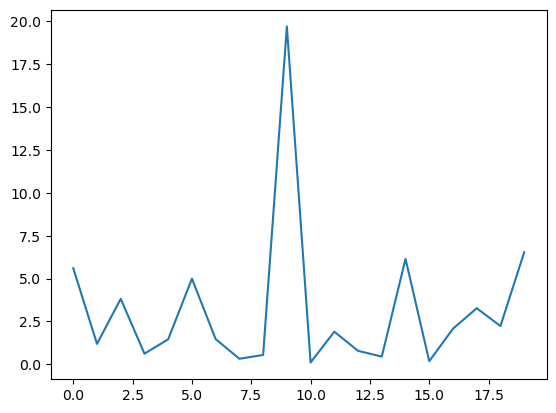

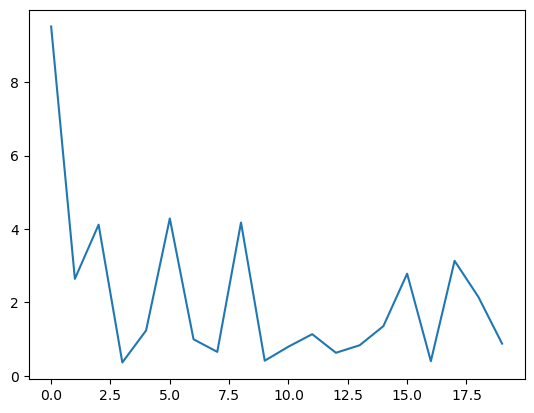

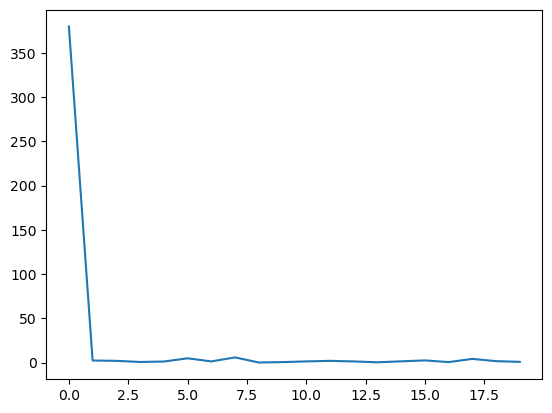

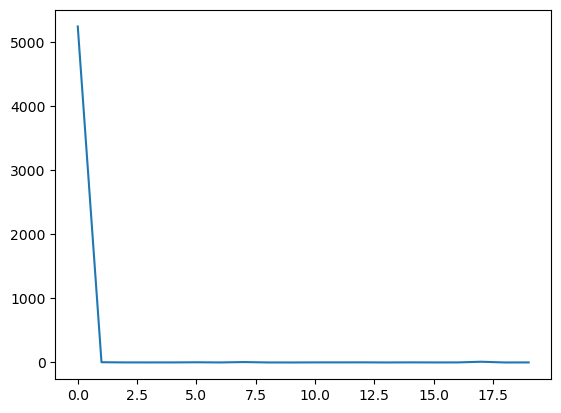

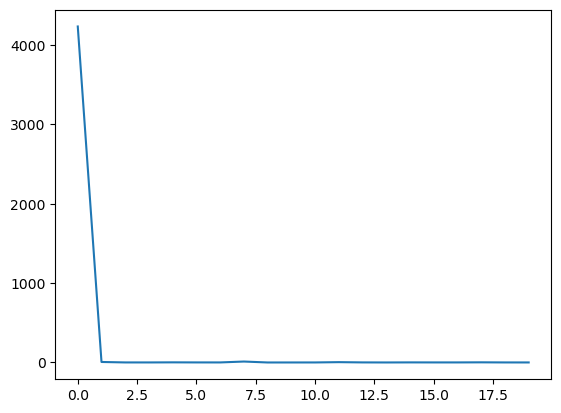

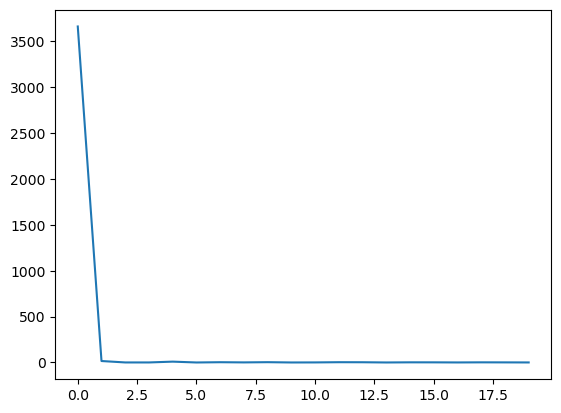

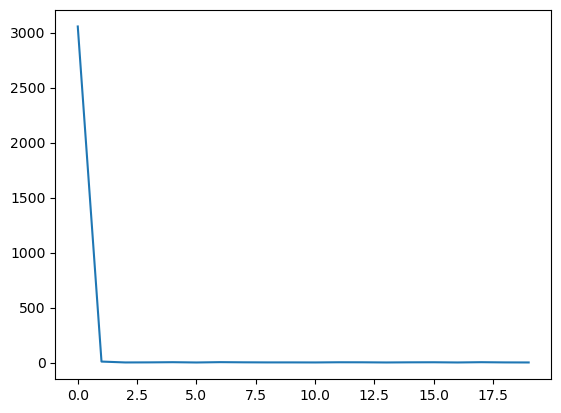

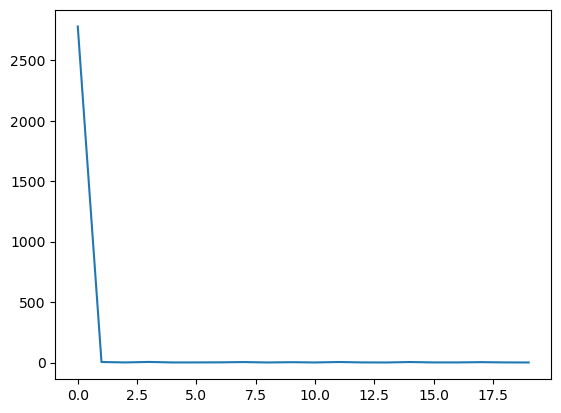

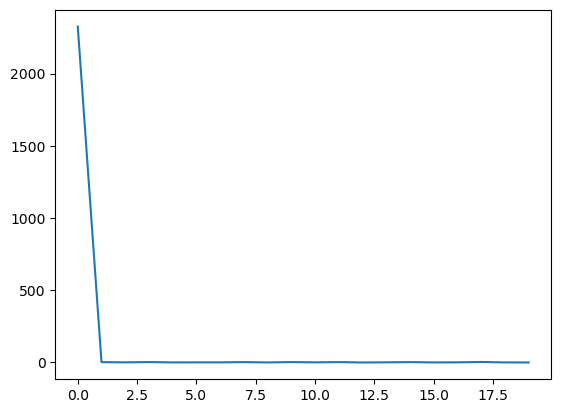

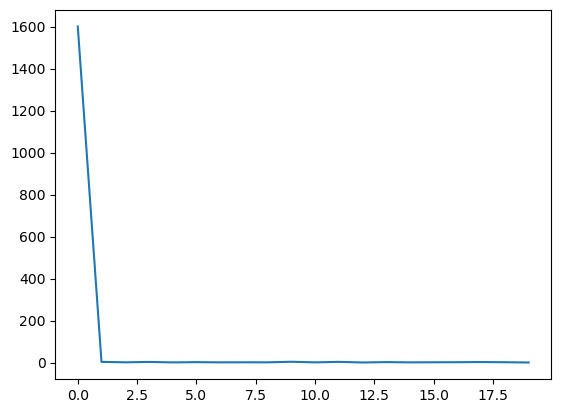

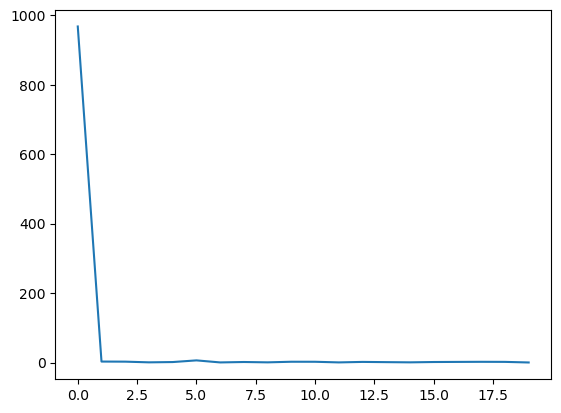

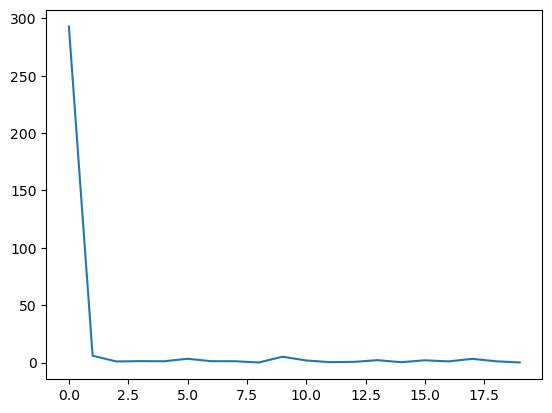

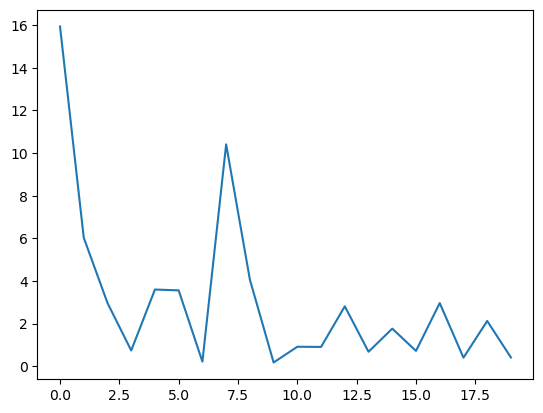

PROMPT DONE:  1


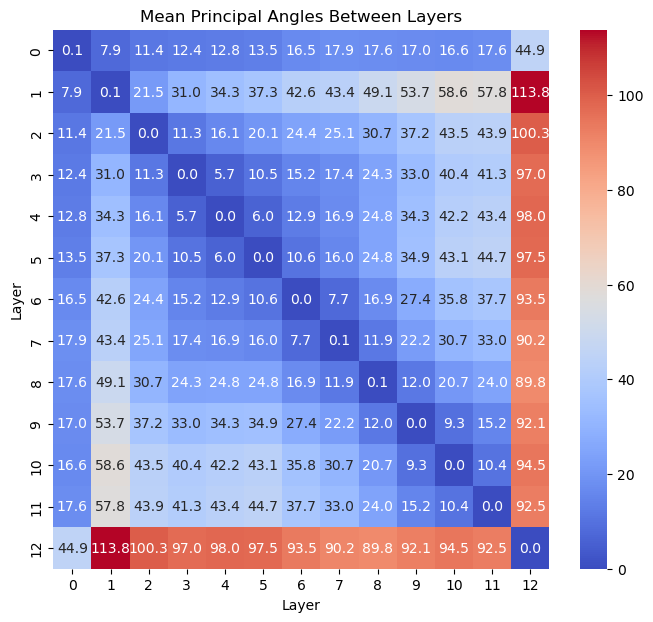

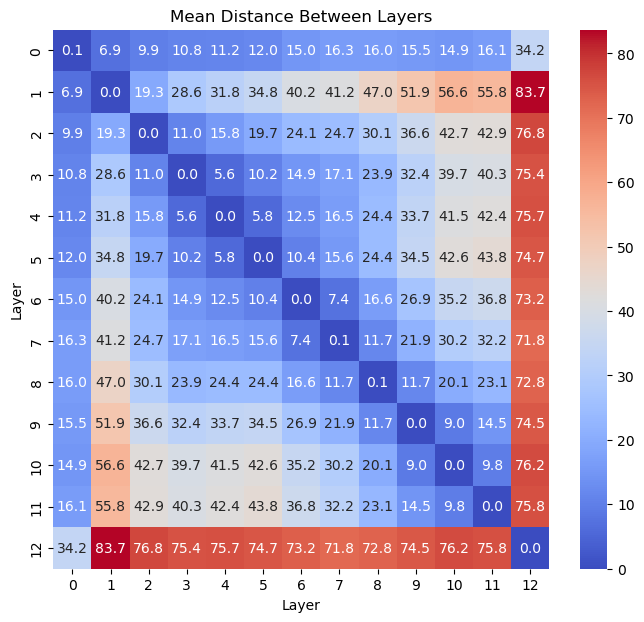

In [137]:
#MAIN


prompt = [
    "If you have five red balls and three blue balls, and you take two away, how many are left?",
    "Explain why the sky is blue in simple terms.",
    "What would happen if gravity on Earth suddenly doubled?",
    "Describe the differences between inductive and deductive reasoning.",
    "A train leaves New York at 60 mph...",
    "Write a short horror story set in a silent library.",
    "Invent a new mythological creature and describe its legend.",
    "Describe a utopian society in 100 words.",
    "Write a dialogue between a robot and a time traveler.",
    "Continue the story: “The last candle flickered, and then...”",
    "Rewrite the Gettysburg Address in modern slang.",
    "Make this tweet sound academic: \"Can’t even with this weather, lol.\"",
    "Turn a recipe into a Shakespearean poem.",
    "Rewrite a Wikipedia article as a fairy tale.",
    "Make a news headline sound like a movie trailer.",
    "Summarize the theme of “1984” in two paragraphs.",
    "Compare Hamlet and Macbeth as tragic heroes.",
    "Analyze the symbolism of the green light in The Great Gatsby.",
    "Describe Emily Dickinson’s writing style.",
    "Write a review of Mary Shelley’s Frankenstein as if it was published today.",
    "Write a Python function to calculate factorial recursively.",
    "Explain what a neural network is to a 10-year-old.",
    "What is the difference between TCP and UDP?",
    "Fix this broken code: `for i in range(10) print(i)`",
    "Write a regex that matches email addresses.",
    "Explain climate change and its main causes.",
    "Summarize the history of the Roman Empire in 5 bullet points.",
    "What are the pros and cons of nuclear energy?",
    "Describe the process of photosynthesis.",
    "What are the main economic consequences of inflation?",
    "What is quantum entanglement?",
    "Explain the theory of evolution by natural selection.",
    "What’s the difference between mitosis and meiosis?",
    "What would life be like on Mars?",
    "Describe the anatomy of the human heart.",
    "You’re in a room with two doors...",
    "Invent a new board game with simple rules.",
    "Generate a riddle that involves numbers and logic.",
    "Simulate a turn of Dungeons & Dragons (DM-style).",
    "Explain the strategy behind chess openings like the Sicilian Defense."
]


pAngle_all = []
dist_all=[]
rows=[]


M = 2  # I TAKE 

for n,i in enumerate(prompt):
    
    hidden_states=inp(i)

    
    plot_gram=False
    U_list=[]
    dimension=[]


    for layer in range(len(hidden_states)):
    
        gram_matrix = Gram(hidden_states[layer][0], hidden_states[layer][0], plot_gram)


        ####################################### defining d ######################
    
        eigenvalues, _ = torch.linalg.eigh(gram_matrix)
        eigenvalues=np.sort(eigenvalues)[::-1]

        

        Q_arr=[]
        for i in range(len(eigenvalues)-2):
            Q=(eigenvalues[i]-eigenvalues[i+1])/(eigenvalues[i+1]-eigenvalues[i+2])
            Q_arr.append(Q)
        plt.plot(np.arange(0,len(Q_arr)), Q_arr)

        plt.show()
        
        Q_max=max(Q_arr)

        if Q_max>4:
            d = np.argmax(Q_arr) + 2
          #  print("Q max is:", Q_max, "and the choosen d is: ", d)
        
        else: 
            print("DANGER")


        dimension.append(d)
        

        U, S, V = torch.svd(gram_matrix)

        U_d = U[:, :d]    
        U_list.append(U_d)


        p_Angle=[]
        dist = []
        for i in range(len(U_list)):
            temp_2=[]
            temp_1=[]
            
            for j in range(len(U_list)):
      
                G_sup=Gram_2(U_list[i], U_list[j])
                angles, S= principle_angle(G_sup)        


                temp_2.append(angles.sum().item())

                temp_1.append(torch.norm(angles).item())

            p_Angle.append(temp_2)
            dist.append(temp_1)

    pAngle_all.append(np.array(p_Angle))
    dist_all.append(np.array(dist))

    ######################################        ######################################


    result = multiple_tokens(  hidden_states, 
                                X_static,
                                vocab, 
                                M,
                                dimension)
    print("PROMPT DONE: ", n+1)

    for layer_idx, (dim_var_list, top_tokens, bottom_tokens) in enumerate(result):
   
        for i, (dim, var) in enumerate(dim_var_list):
            row = {
                "layer": layer_idx,
                "dimension": dim,
                "variance": var,
                "top_tokens": top_tokens[i],
                "bottom_tokens": bottom_tokens[i]
            }
            rows.append(row)
    break


    ######################################        ######################################




pAngle_all = np.stack(pAngle_all)  # shape: (num_prompts, num_layers, num_layers)
heat_mean = pAngle_all.mean(axis=0)  # shape: (num_layers, num_layers)

plt.figure(figsize=(8, 7))
sns.heatmap(heat_mean, cmap="coolwarm", fmt=".1f", annot=True)
plt.title("Mean Principal Angles Between Layers")
plt.xlabel("Layer")
plt.ylabel("Layer")
plt.show()


dist_all = np.stack(dist_all)  # shape: (num_prompts, num_layers, num_layers)
heat_mean_dist = dist_all.mean(axis=0)  # shape: (num_layers, num_layers)

 
plt.figure(figsize=(8, 7))
sns.heatmap(heat_mean_dist, cmap="coolwarm", fmt=".1f", annot=True)
plt.title("Mean Distance Between Layers")
plt.xlabel("Layer")
plt.ylabel("Layer")
plt.show()
    


In [ ]:


# What if I do a more empirical thing. I see witch dimension are the most importante (witch dimension more influence 
# the dimension and I see witch are the most influent and try to cathegorize them into grammar/semantic....

#I can try different kind of prompt and see how principle angle change (if change)

In [120]:


df = pd.DataFrame(rows)
#0 dim+ variance
# botton_token
# top token

In [133]:
layer=df.groupby("layer")["dimension"].count()
print((layer))

layer
0     322
1     204
2     164
3     164
4     164
5     164
6     164
7     164
8     164
9     164
10    164
11    170
12    248
Name: dimension, dtype: int64
